In [63]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline import CustomFactor, CustomFilter
from quantopian.research import run_pipeline
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import Latest, Returns, AnnualizedVolatility
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.filters.morningstar import IsPrimaryShare
from quantopian.pipeline.data.zacks import broker_ratings
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from statsmodels import regression

#### Define Parameters

In [64]:
start_date = '2017-06-19'
end_date = '2017-06-19'

#### Define Filters and Factors

In [65]:
# security filters
common_stock = morningstar.share_class_reference.security_type.latest.eq('ST00000001')
not_lp_name = ~morningstar.company_reference.standard_name.latest.matches('.* L[\\. ]?P\.?$')
not_lp_balance_sheet = morningstar.balance_sheet.limited_partnership.latest.isnull()
have_data = morningstar.valuation.market_cap.latest.notnull()
not_otc = ~morningstar.share_class_reference.exchange_id.latest.startswith('OTC')
not_wi = ~morningstar.share_class_reference.symbol.latest.endswith('.WI')
not_depository = ~morningstar.share_class_reference.is_depositary_receipt.latest
primary_share = IsPrimaryShare()

tradeable_filter = (common_stock & not_lp_name & not_lp_balance_sheet &
                   have_data & not_otc & not_wi & not_depository & primary_share)

In [66]:
# custom factors
is_primary_share = morningstar.share_class_reference.is_primary_share.latest  
last_close_price = USEquityPricing.close.latest
mkt_cap = MarketCap(mask=tradeable_filter) / 1e9
sector = morningstar.asset_classification.morningstar_sector_code.latest

# Filter for the top X securities by market cap.  
top_mkt_cap = mkt_cap >= 1

rtn_22 = Returns(window_length=22, mask=top_mkt_cap)
rtn_21 = Returns(window_length=21, mask=top_mkt_cap)
rtn_20 = Returns(window_length=20, mask=top_mkt_cap)
rtn_19 = Returns(window_length=19, mask=top_mkt_cap)
rtn_18 = Returns(window_length=18, mask=top_mkt_cap)

mean_rev_1M = (rtn_22 + rtn_21 + rtn_20 + rtn_19 + rtn_18) / 5.
mom_1Y = Returns(window_length=252, mask=top_mkt_cap)
mean_rev_3Y = Returns(window_length=756, mask=top_mkt_cap)

pipe = Pipeline(
    columns={'last_price': last_close_price,
             'size': mkt_cap / 1e9,
             'mean_rev_1M': mean_rev_1M * 1e2,
             'mom_1Y' : mom_1Y * 1e2,
             'mean_rev_3Y' : mean_rev_3Y * 1e2,
             'sector':sector
            },
    screen = top_mkt_cap
)

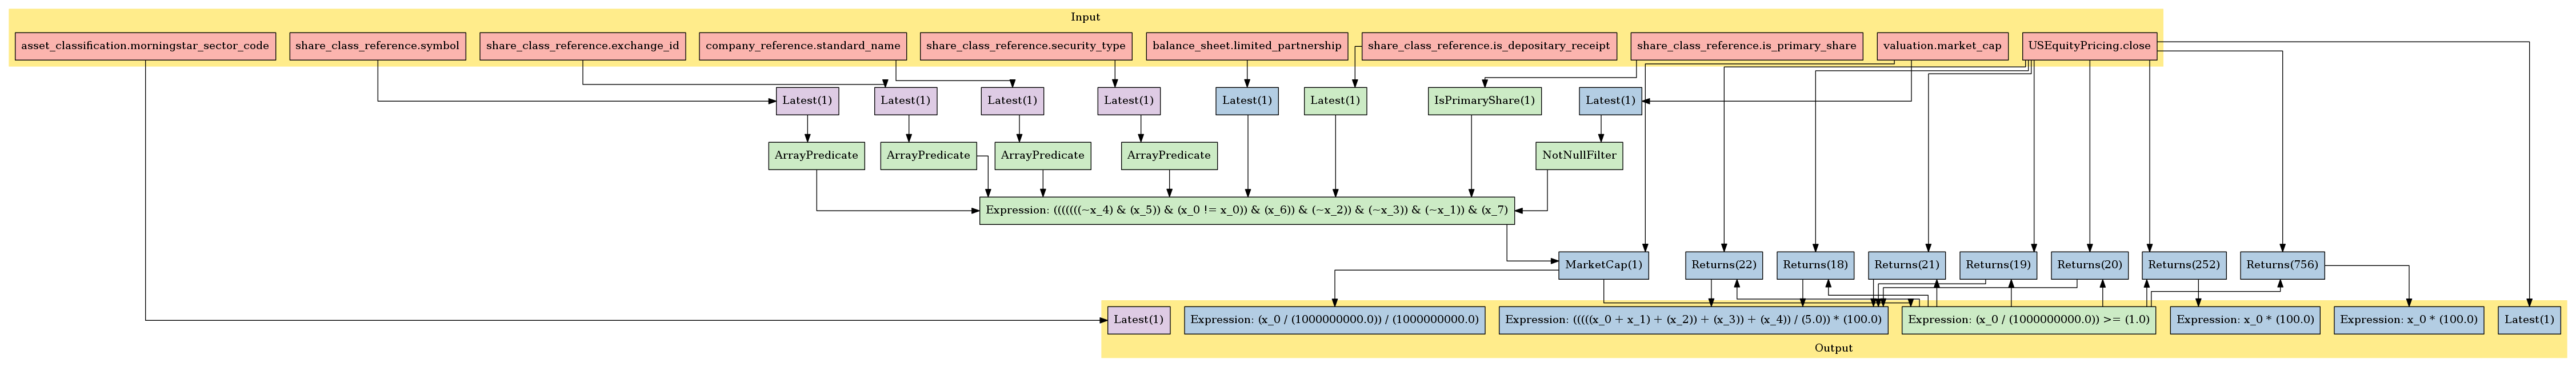

In [67]:
pipe.show_graph(format='png')

In [68]:
pipe_output = run_pipeline(pipe, start_date=start_date, end_date=end_date)
pipe_output.head(5)

last_price  mean_rev_1M  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])      142.26    -6.835622   
                          Equity(31 [ABAX])       50.86     7.746465   
                          Equity(52 [ABM])        41.74     0.370310   
                          Equity(53 [ABMD])      143.39     7.211401   
                          Equity(62 [ABT])        48.21    11.263102   

                                             mean_rev_3Y     mom_1Y  sector  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])    63.320522  52.102549     311   
                          Equity(31 [ABAX])    21.128960  14.621411     206   
                          Equity(52 [ABM])     67.700990  17.038117     310   
                          Equity(53 [ABMD])   513.301967  44.444444     206   
                          Equity(62 [ABT])     27.986949  32.275060     206   

                                                     size  
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])  7.417730e-07  
                          Equity(31 [ABAX])  1.152180e-09  
                          Equity(52 [ABM])   2.329500e-09  
                          Equity(53 [ABMD])  6.283250e-09  
                          Equity(62 [ABT])   8.365750e-08

In [69]:
pipe_output.sort_values('mom_1Y', ascending=False)

last_price  mean_rev_1M  \
2017-06-19 00:00:00+00:00 Equity(4982 [TELL])        10.110     0.575985   
                          Equity(45130 [STRP])      179.380     0.164585   
                          Equity(45503 [AAOI])       62.880    -4.218901   
                          Equity(17401 [LKFN])       45.980     6.311093   
                          Equity(42166 [CLVS])       59.910    12.415184   
                          Equity(49210 [CC])         36.710   -15.211623   
                          Equity(43124 [TSRO])      144.350    -5.296478   
                          Equity(25764 [KRO])        17.720    -7.466816   
                          Equity(19725 [NVDA])      151.500    12.738862   
                          Equity(371 [TVTY])         37.600    16.235461   
                          Equity(47432 [LOXO])       72.130    56.312381   
                          Equity(49060 [SHOP])       86.910    -3.491145   
                          Equity(22364 [EXAS])       32.270     3.787306   
                          Equity(40530 [TROX])       13.580   -25.384292   
                          Equity(47332 [SAGE])       79.710    19.681980   
                          Equity(22637 [SGMS])       25.950    11.978818   
                          Equity(45733 [AERI])       49.950    23.169340   
                          Equity(19973 [EXTR])        9.610     6.531301   
                          Equity(44935 [BLUE])      108.750    30.832432   
                          Equity(46929 [TRUE])       18.850     8.333797   
                          Equity(49222 [TDOC])       34.000    18.721466   
                          Equity(49610 [SQ])         23.550    15.886294   
                          Equity(27780 [IRBT])       96.300     2.944352   
                          Equity(1751 [COHR])       241.000    -2.621463   
                          Equity(45800 [WIX])        69.250    -6.299822   
                          Equity(21383 [EXEL])       19.260    -3.291323   
                          Equity(49288 [LITE])       63.100    15.871754   
                          Equity(42689 [PBYI])       77.900    81.314524   
                          Equity(3274 [GNCM_A])      36.650     3.407223   
                          Equity(5121 [MU])          29.860     7.749907   
...                                                     ...          ...   
                          Equity(50633 [JAG])        12.960    -1.698233   
                          Equity(50634 [JELD])       34.310    11.886615   
                          Equity(50636 [REVG])       29.920    14.036798   
                          Equity(50639 [LAUR])       18.170    15.515425   
                          Equity(50642 [INVH])       21.210    -1.990082   
                          Equity(50683 [SNAP])       17.520   -12.515287   
                          Equity(50690 [CJ])         34.180     0.767596   
                          Equity(50695 [PSDO])       15.010    12.198329   
                          Equity(50702 [PLYA])       10.730     5.429842   
                          Equity(50716 [DXC])        74.830    -4.491614   
                          Equity(50718 [PUMP])       13.480     1.582865   
                          Equity(50719 [MULE])       24.690     3.290154   
                          Equity(50735 [AYX])        18.700     4.042544   
                          Equity(50749 [BTU])        23.540     0.703798   
                          Equity(50758 [OKTA])       26.480    10.782252   
                          Equity(50763 [SNDR])       21.200    13.254105   
                          Equity(50779 [CADE])       22.720     4.132192   
                          Equity(50781 [YEXT])       13.340     0.679911   
                          Equity(50782 [UPL])        11.490    -2.141041   
                          Equity(50798 [FND])        40.420     9.750491   
                          Equity(50806 [NCSM])       23.320    -1.108705   
                     

In [70]:
pipe_raw = pipe_output[['sector', 'size', 'mean_rev_1M','mom_1Y','mean_rev_3Y']]
pipe_raw.head()

sector          size  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])     311  7.417730e-07   
                          Equity(31 [ABAX])     206  1.152180e-09   
                          Equity(52 [ABM])      310  2.329500e-09   
                          Equity(53 [ABMD])     206  6.283250e-09   
                          Equity(62 [ABT])      206  8.365750e-08   

                                             mean_rev_1M     mom_1Y  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])    -6.835622  52.102549   
                          Equity(31 [ABAX])     7.746465  14.621411   
                          Equity(52 [ABM])      0.370310  17.038117   
                          Equity(53 [ABMD])     7.211401  44.444444   
                          Equity(62 [ABT])     11.263102  32.275060   

                                             mean_rev_3Y  
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])    63.320522  
                          Equity(31 [ABAX])    21.128960  
                          Equity(52 [ABM])     67.700990  
                          Equity(53 [ABMD])   513.301967  
                          Equity(62 [ABT])     27.986949

#### Allocate Factor Weights and Settings

In [71]:
factors = {'size':{'ascending':True, 'weight':0.623},
           'mean_rev_1M':{'ascending':False, 'weight':0.146},
           'mom_1Y':{'ascending':True, 'weight':0.113},
           'mean_rev_3Y':{'ascending':False, 'weight':0.117},
          }

factor_weights = 0
for factor_key, factor_vals in factors.items():
    factor_weights += factor_vals['weight']
print ("Totals Weight = %f" % (factor_weights * 100.))
factors

Totals Weight = 99.900000


{'mean_rev_1M': {'ascending': False, 'weight': 0.146},
 'mean_rev_3Y': {'ascending': False, 'weight': 0.117},
 'mom_1Y': {'ascending': True, 'weight': 0.113},
 'size': {'ascending': True, 'weight': 0.623}}

#### Compute Factor Ranks and Scores

In [72]:
pipe_rank = pd.DataFrame(data=None, index=pipe_raw.index)
pipe_sector = pipe_raw.groupby('sector')

# universe rank
pipe_rank['sector'] = pipe_raw['sector']
for factor_key, factor_vals in factors.items():
    pipe_rank[factor_key + '_univ'] = pipe_raw[factor_key].rank(ascending=factor_vals['ascending'], pct=True)
    pipe_rank[factor_key + '_sector'] = pipe_sector[factor_key].rank(ascending=factor_vals['ascending'], pct=True)
    pipe_rank[factor_key + '_score'] = (0.5 * pipe_rank[factor_key + '_univ']) + (0.5 * pipe_rank[factor_key + '_sector'])

pipe_rank.head(5)

sector  mean_rev_1M_univ  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])     311          0.929330   
                          Equity(31 [ABAX])     206          0.161530   
                          Equity(52 [ABM])      310          0.727949   
                          Equity(53 [ABMD])     206          0.187035   
                          Equity(62 [ABT])      206          0.057917   

                                             mean_rev_1M_sector  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])            0.941818   
                          Equity(31 [ABAX])            0.230769   
                          Equity(52 [ABM])             0.774436   
                          Equity(53 [ABMD])            0.246154   
                          Equity(62 [ABT])             0.123077   

                                             mean_rev_1M_score  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])           0.935574   
                          Equity(31 [ABAX])           0.196150   
                          Equity(52 [ABM])            0.751193   
                          Equity(53 [ABMD])           0.216594   
                          Equity(62 [ABT])            0.090497   

                                             mean_rev_3Y_univ  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])          0.273104   
                          Equity(31 [ABAX])          0.597156   
                          Equity(52 [ABM])           0.243483   
                          Equity(53 [ABMD])          0.002370   
                          Equity(62 [ABT])           0.552725   

                                             mean_rev_3Y_sector  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])            0.422131   
                          Equity(31 [ABAX])            0.706897   
                          Equity(52 [ABM])             0.205534   
                          Equity(53 [ABMD])            0.005747   
                          Equity(62 [ABT])             0.655172   

                                             mean_rev_3Y_score  mom_1Y_univ  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])           0.347618     0.836634   
                          Equity(31 [ABAX])           0.652026     0.387789   
                          Equity(52 [ABM])            0.224509     0.427943   
                          Equity(53 [ABMD])           0.004058     0.776128   
                          Equity(62 [ABT])            0.603949     0.641364   

                                             mom_1Y_sector  mom_1Y_score  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])       0.721190      0.778912   
                          Equity(31 [ABAX])       0.347150      0.367470   
                          Equity(52 [ABM])        0.387833      0.407888   
                          Equity(53 [ABMD])       0.694301      0.735214   
                          Equity(62 [ABT])        0.569948      0.605656   

                                             size_univ  size_sector  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])   1.000000     1.000000   
                          Equity(31 [ABAX])   0.057203     0.061538   
                          Equity(52 [ABM])    0.331568     0.352060   
                          Equity(53 [ABMD])   0.653072     0.615385   
                          Equity(62 [ABT])    0.968750     0.943590   

                                             size_score  
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])    1.000000  
                          Equity(31 [ABAX])    0.059371  
                          Equity(52 [ABM])     0.341814  
                          Equity(53 [ABMD])    0.634228  
                          Equity(62 [ABT])     0.956170

#### Compute Final Score

In [73]:
def final_score(X, f):
    tmp = None
    for factor_key, factor_vals in factors.items():
        wgt = X[factor_key + '_score'] * factor_vals['weight']
        tmp = wgt if tmp is None else tmp + wgt
    return tmp

pipe_rank['score'] = pipe_rank.apply(final_score, args = (factors,), axis=1)
pipe_rank

sector  mean_rev_1M_univ  \
2017-06-19 00:00:00+00:00 Equity(24 [AAPL])        311          0.929330   
                          Equity(31 [ABAX])        206          0.161530   
                          Equity(52 [ABM])         310          0.727949   
                          Equity(53 [ABMD])        206          0.187035   
                          Equity(62 [ABT])         206          0.057917   
                          Equity(67 [ADSK])        311          0.727418   
                          Equity(76 [TAP])         205          0.934113   
                          Equity(110 [ACXM])       311          0.663656   
                          Equity(114 [ADBE])       311          0.687035   
                          Equity(122 [ADI])        311          0.772051   
                          Equity(128 [ADM])        205          0.616897   
                          Equity(161 [AEP])        207          0.326780   
                          Equity(166 [AES])        207          0.288523   
                          Equity(168 [AET])        206          0.199256   
                          Equity(185 [AFL])        103          0.230074   
                          Equity(197 [AGCO])       310          0.243358   
                          Equity(216 [HES])        309          0.955898   
                          Equity(239 [AIG])        103          0.425611   
                          Equity(247 [AIN])        102          0.045165   
                          Equity(253 [AIR])        310          0.418172   
                          Equity(266 [AJG])        103          0.237513   
                          Equity(270 [AKRX])       206          0.682253   
                          Equity(289 [MATX])       310          0.570138   
                          Equity(300 [ALK])        310          0.292774   
                          Equity(301 [ALKS])       206          0.800213   
                          Equity(332 [ALX])        104          0.377790   
                          Equity(337 [AMAT])       311          0.834219   
                          Equity(351 [AMD])        311          0.568013   
                          Equity(353 [AME])        310          0.435707   
                          Equity(357 [TWX])        102          0.596706   
...                                                ...               ...   
                          Equity(50633 [JAG])      309          0.824655   
                          Equity(50634 [JELD])      -1          0.050478   
                          Equity(50636 [REVG])      -1          0.030287   
                          Equity(50639 [LAUR])     205          0.022848   
                          Equity(50642 [INVH])      -1          0.833688   
                          Equity(50683 [SNAP])      -1          0.972370   
                          Equity(50690 [CJ])       309          0.695537   
                          Equity(50695 [PSDO])      -1          0.045696   
                          Equity(50702 [PLYA])      -1          0.306057   
                          Equity(50716 [DXC])      311          0.896387   
                          Equity(50718 [PUMP])     309          0.639745   
                          Equity(50719 [MULE])      -1          0.493624   
                          Equity(50735 [AYX])      311          0.438895   
                          Equity(50749 [BTU])      101          0.701913   
                          Equity(50758 [OKTA])      -1          0.066419   
                          Equity(50763 [SNDR])     310          0.036132   
                          Equity(50779 [CADE])      -1          0.429862   
                          Equity(50781 [YEXT])     311          0.704038   
                          Equity(50782 [UPL])      309          0.843252   
                          Equity(50798 [FND])       -1          0.087141   
                          Equity(50806 [NCSM])      -1          0.802338   
                    